**legacy data loding.**

using cv2 and resize to reduce dimension of the data. use if keras data loader is not working properly:

In [ ]:
# loading data
dataset = np.zeros((1818,256,256,3))
for i in range(0,1818):
  path = '/content/drive/MyDrive/data/'+ str(i)+ '.jpg'
  img = cv2.imread(path,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_AREA)
  img = np.array(img).astype('float16')
  img = img/255
  dataset[i] = img

**importing stuff**

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory as loadds
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
import cv2
from matplotlib import pyplot as plt


**warninng:** data loading using keras data loader, keep the batch size small due to the sheer size of the model.
free version of google colab would be enough


In [ ]:
# dataset
dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data',
                                                      labels=None,
                                                      image_size= (512,256),
                                                      shuffle=True,
                                                      batch_size =10 ,
                                                      color_mode = 'rgb',
                                                      crop_to_aspect_ratio=False
                                                      )
def crop_image(image):
    cropped_image = tf.image.crop_to_bounding_box(image,70,150,512, 256)
    return cropped_image


def normalize(ds):
  ds = ds/255.0
  return ds
dataset = dataset.map(normalize)
#dataset = dataset.map(crop_image)


Found 1801 files belonging to 1 classes.


In [ ]:
# latent space variables
class Z_block(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 3

In [ ]:
pp_input = Input(shape = (512,256),name = 'pp_input')
x = RandomCrop(256,256,name = 'random_crop_layer')(pp_input)
x = RandomFlip(name = 'ranodmflip')(x)
x = RandomRotation(factor = ((0.4)),fill_mode = "reflect")(x)
pp_model = Model(pp_input,x)


encoder_in = Input(shape = (256,256,3))
x = Conv2D(512,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(encoder_in)
x = Conv2D(256,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(128,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(64,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(32,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(16,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2D(8,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Dense(16,activation = 'linear')(x)
x = Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Z_block()([z_mean, z_log_var])
encoder_model = Model(encoder_in, [z_mean, z_log_var, z], name="encoder")


decoder_in = Input(shape = (latent_dim,))
x = Dense(4*4*4,'linear')(decoder_in)
x = Reshape((4,4,4))(x)
x = Conv2DTranspose(8,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 1)(x)
x = Conv2DTranspose(16,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(32,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(64,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(128,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(256,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(512,kernel_size = (5,5),padding = 'same',activation = 'elu',strides = 2)(x)
x = Conv2DTranspose(3,kernel_size  = (5,5),padding = 'same',activation = 'linear',strides = 1)(x)
decoder_model = Model(decoder_in,x)

class AE(tf.keras.Model):
  def __init__(self, pp, encoder,decoder, **kwargs):
    super(AE, self).__init__(**kwargs)
    self.pp = pp
    self.encoder = encoder
    self.decoder = decoder

    self.reconstruction_loss_tracker = tf.keras.metrics.Mean( name="reconstruction_loss")
    self.kl_loss_tracker = tf.keras.metrics.Mean( name="kl_loss")
    self.total_loss_tracker = tf.keras.metrics.Mean( name="total_loss")


  @property
  def metrics(self):
    return [self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker]

  def train_step(self, data):
      with tf.GradientTape() as tape:
          pp_out  = self.pp(data)
          z_mean, z_log_var, z = self.encoder(pp_out)
          kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.keras.losses.mae(pp_out, reconstruction)
          total_loss = kl_loss + reconstruction_loss

      grads = tape.gradient(total_loss , self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      self.total_loss_tracker.update_state(total_loss)

      return { "reconstruction_loss": self.reconstruction_loss_tracker.result(),
               "kl_loss": self.kl_loss_tracker.result(),
               "total_loss": self.total_loss_tracker.result()
              }

autoencoder = AE(pp_model,encoder_model,decoder_model)


In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam())
autoencoder.fit(dataset,epochs = 5)

Epoch 1/5
181/181 [==============================] - 267s 1s/step - reconstruction_loss: 0.1723 - kl_loss: 0.3045 - total_loss: 0.4783
Epoch 2/5
181/181 [==============================] - 272s 2s/step - reconstruction_loss: 0.1675 - kl_loss: 2.8553e-04 - total_loss: 0.1678
Epoch 3/5
181/181 [==============================] - 272s 2s/step - reconstruction_loss: 0.1670 - kl_loss: 1.5630e-04 - total_loss: 0.1672
Epoch 4/5
181/181 [==============================] - 272s 2s/step - reconstruction_loss: 0.1671 - kl_loss: 1.1403e-04 - total_loss: 0.1672
Epoch 5/5
181/181 [==============================] - 272s 2s/step - reconstruction_loss: 0.1701 - kl_loss: 8.8610e-05 - total_loss: 0.1702


FloatSlider(value=3.0, continuous_update=False, description='dimension1', layout=Layout(width='80%'), max=3.0,…

FloatSlider(value=-0.34, continuous_update=False, description='dimension2', layout=Layout(width='80%'), max=3.…

FloatSlider(value=-3.0, continuous_update=False, description='dimension3', layout=Layout(width='80%'), max=3.0…

Button(description='Execute', style=ButtonStyle())

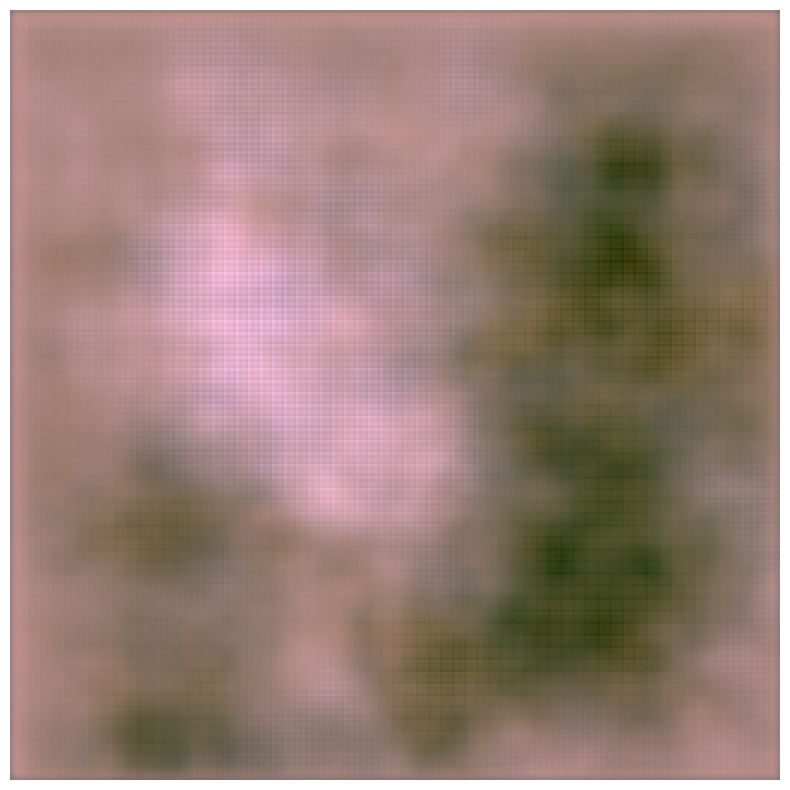

In [ ]:
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

plt.figure(figsize= (20,20))
def func(sliders):
    # Clear the previous image
    clear_output(wait=True)
    z_input = np.zeros((1, latent_dim))
    for i, slider in enumerate(sliders):
        z_input[0, i] = slider.value

    out_pic = np.array(autoencoder.decoder.predict(z_input, verbose=False))
    out_pic = (out_pic - out_pic.min())/(out_pic.max() - out_pic.min())
    display(*sliders,button)
    # Display the new image
    plt.figure(figsize= (10,10))
    plt.imshow(out_pic[0])
    plt.axis('off')
    plt.show()


s = []
for dim in range(1,latent_dim+1):
  w = widgets.FloatSlider(
    value=0,
    min=-3,
    max=3,
    step=0.01,
    description='dimension'+str(dim),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.6f',
    layout=widgets.Layout(width='80%')
  )
  display(w)
  s.append(w)
button = widgets.Button(description="Execute")
button.on_click(lambda _: func(s))
display(button)
